<a href="https://colab.research.google.com/github/REYES-AFMR/BEELEC1-EG1_Group2/blob/main/ReddyDuliCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTING: Import relevant libraries

# will emable you to manipulate files purely online (interacts with operating system)
import os

# numerical operations (matrices)
import numpy as np

import keras
from keras import utils
from keras.utils import to_categorical
from keras import layers
from keras.layers import Conv2D, AveragePooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy, AUC, F1Score
from keras.optimizers import Adam
from keras.utils import to_categorical

# computer vision and image processing
import cv2

# train test split
from sklearn.model_selection import train_test_split

# plots and charts
import matplotlib.pyplot as plt
# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from types import NoneType

In [ ]:
# LOADING IMAGES:
from google.colab import drive
drive.mount('/content/drive')
datasetPath = '/content/drive/Shared drives/BEELEC1/Dataset'

# getting MRI images
pathMRI = os.path.join(datasetPath, "Brain Tumor MRI images")
pathTumorMRI = os.path.join(pathMRI, "Tumor")
pathHealthyMRI = os.path.join(pathMRI, "Healthy")

# getting CT scan images
pathCT = os.path.join(datasetPath, "Brain Tumor CT scan Images")
pathTumorCT = os.path.join(pathCT, "Tumor")
pathHealthyCT = os.path.join(pathCT, "Healthy")

# loading into respective arrays
dataMRI = []
labelMRI = []

for i in os.listdir(pathTumorMRI):
  tempImg = cv2.imread(os.path.join(pathTumorMRI, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256)) # resizing for uniformity
    dataMRI.append(resizedImg)
    labelMRI.append(1)
  else:
    continue

for i in os.listdir(pathHealthyMRI):
  tempImg = cv2.imread(os.path.join(pathHealthyMRI, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256))
    dataMRI.append(resizedImg)
    labelMRI.append(0)
  else:
    continue

dataCT = []
labelCT = []

for i in os.listdir(pathTumorCT):
  tempImg = cv2.imread(os.path.join(pathTumorCT, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256))
    dataCT.append(resizedImg)
    labelCT.append(1)
  else:
    continue

for i in os.listdir(pathHealthyCT):
  tempImg = cv2.imread(os.path.join(pathHealthyCT, i))
  if type(tempImg) is not NoneType:
    resizedImg = cv2.resize(tempImg, (256, 256))
    dataCT.append(resizedImg)
    labelCT.append(0)
  else:
    continue

print("IMAGE SIZES:")
print(f"MRIs images = {np.array(dataMRI).shape}, MRI labels = {to_categorical(np.array(labelMRI)).shape}")
print(f"CT scans = {np.array(dataCT).shape}, CT labels = {to_categorical(np.array(labelCT)).shape}")

Mounted at /content/drive
IMAGE SIZES:
MRIs images = (5000, 256, 256, 3), MRI labels = (5000, 2)
CT scans = (4618, 256, 256, 3), CT labels = (4618, 2)


MRIs images = (5000, 256, 256), MRI labels = (5000, 2)


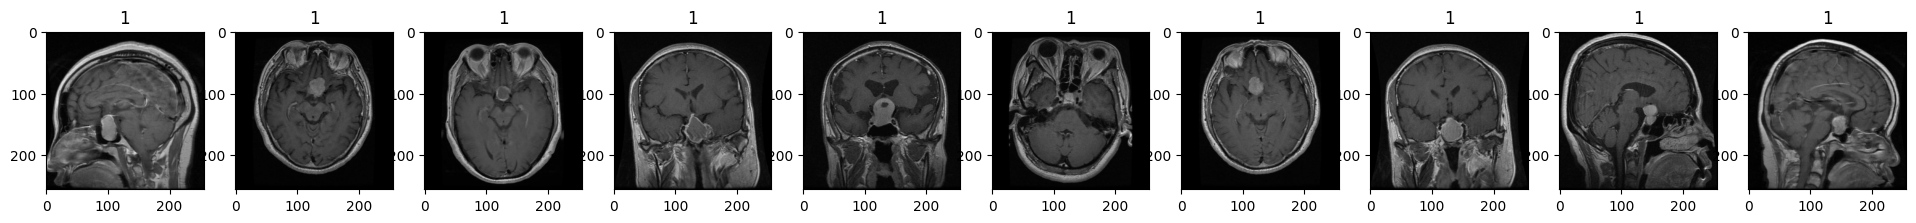

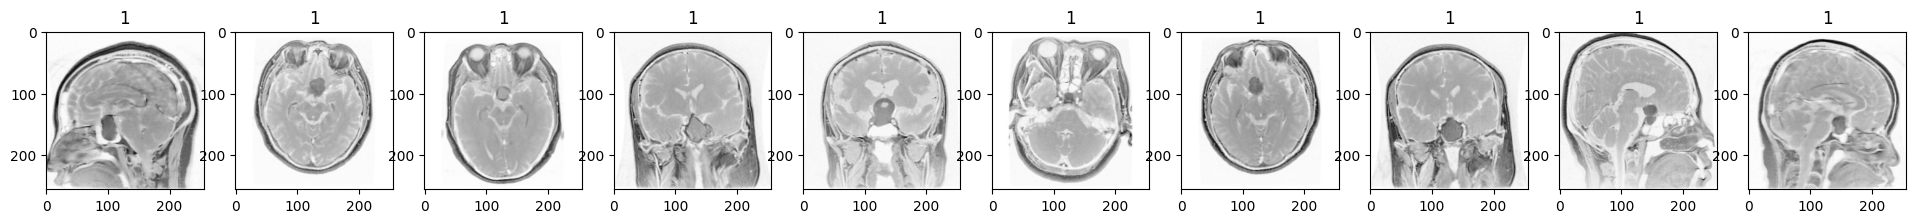

In [ ]:
# PREPROCESSING: MRI
# best method: unsharp masking + bilateral filter. SigmaX 3, alpha 1.5, filter size 9, sigmaColor 75 sigmaSpace 75
# grayscale -> unsharp masking process: gaussian blur, 1.5 weight OG image + -0.5 weight blurred image -> pass through bilaterial filter

# unsharp masking process can be used using cv2's addWeighted() function

dataMRIpro = []

for i in dataMRI:
  # convert to grayscale values
  imgGS = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  # denoise with gaussian blur with size 9 (3x3)
  imgGB = cv2.GaussianBlur(imgGS, (3,3), 0)
  # add the weighted images for unsharp masking with alpha 1.5, beta -0.5
  imgUM = cv2.addWeighted(imgGS, 1.5, imgGB, -0.5, 0)
  # pass result into a bilateral filter with sigmaX 3, sigmaColor 75, and sigmaSpace 75
  imgBF = cv2.bilateralFilter(imgUM, 3, 75, 75)
  dataMRIpro.append(imgBF)

# showing results
size = 10

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display original image
    ax[i].imshow(dataMRI[i], cmap='binary')
    ax[i].set_title(labelMRI[i])

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display processed
    ax[i].imshow(dataMRIpro[i], cmap='binary')
    ax[i].set_title(labelMRI[i])

print(f"MRIs images = {np.array(dataMRIpro).shape}, MRI labels = {to_categorical(np.array(labelMRI)).shape}")

CT scans = (4618, 256, 256), CT labels = (4618, 2)


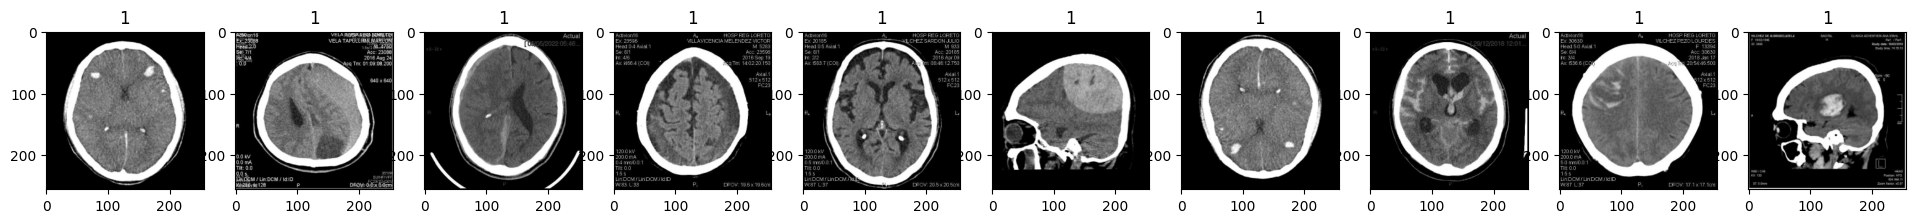

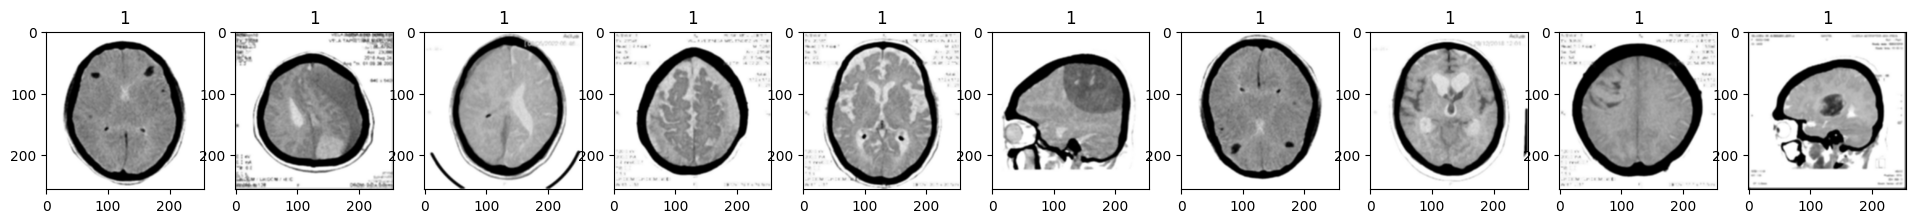

In [ ]:
# PREPROCESSING: CT
# best method: median-mean hybrid filter. window size 3x3
# grayscale -> pass through median filter -> pass through mean filter
# while usually done for median filters, padding is unnecessary as medical images in use already have black borders

dataCTpro = []

for i in dataCT:
  # convert to grayscale values
  imgGS = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
  # median filter kernel size 3 (3x3 window)
  imgMed = cv2.medianBlur(imgGS, 3)
  # mean filter kernel shape 3x3
  imgMean = cv2.blur(imgMed, (3,3))
  dataCTpro.append(imgMean)

# showing results
size = 10

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display original image
    ax[i].imshow(dataCT[i], cmap='binary')
    ax[i].set_title(labelCT[i])

fig, ax = plt.subplots(1, size, figsize=(24, 24))

for i in range(0, size):
    # display masks
    ax[i].imshow(dataCTpro[i], cmap='binary')
    ax[i].set_title(labelCT[i])

print(f"CT scans = {np.array(dataCTpro).shape}, CT labels = {to_categorical(np.array(labelCT)).shape}")

In [ ]:
# splitting into training and testing groups
# 80% training 20% testing. stratification to ensure class proportions are equal between training and testing sets

dataMRItrain, dataMRItest, labelMRItrain, labelMRItest = train_test_split(dataMRIpro, labelMRI, test_size=0.2, stratify=labelMRI)

dataCTtrain, dataCTtest, labelCTtrain, labelCTtest = train_test_split(dataCTpro, labelCT, test_size=0.2, stratify=labelCT)

# conversion to numpy arrays
dataMRItrainNP = np.array(dataMRItrain)
labelMRItrainNP = to_categorical(np.array(labelMRItrain))
dataMRItestNP = np.array(dataMRItest)
labelMRItestNP = to_categorical(np.array(labelMRItest))

dataCTtrainNP = np.array(dataCTtrain)
labelCTtrainNP = to_categorical(np.array(labelCTtrain))
dataCTtestNP = np.array(dataCTtest)
labelCTtestNP = to_categorical(np.array(labelCTtest))

print("MRI SET SIZES:")
print(f"Training Images = {dataMRItrainNP.shape}, Training Labels = {labelMRItrainNP.shape}")
print(f"Testing Images {dataMRItestNP.shape}, Testing Labels = {labelMRItestNP.shape}")

print("CT SET SIZES:")
print(f"Training Images = {dataCTtrainNP.shape}, Training Labels = {labelCTtrainNP.shape}")
print(f"Testing Images {dataCTtestNP.shape}, Testing Labels = {labelCTtestNP.shape}")

MRI SET SIZES:
Training Images = (4000, 256, 256), Training Labels = (4000, 2)
Testing Images (1000, 256, 256), Testing Labels = (1000, 2)
CT SET SIZES:
Training Images = (3694, 256, 256), Training Labels = (3694, 2)
Testing Images (924, 256, 256), Testing Labels = (924, 2)


In [ ]:
cnnModel = keras.Sequential()

# ConvNet BLOCK 1
cnnModel.add(Conv2D(32, (5,5), 2, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

# BLOCK 2
cnnModel.add(Conv2D(48, (3,3), 2, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(48, (3,3), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(48, (1,1), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(AveragePooling2D(pool_size=(2,2), strides=2))

# BLOCK 3
cnnModel.add(Conv2D(64, (3,3), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(64, (3,3), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(64, (1,1), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(AveragePooling2D(pool_size=(2,2), strides=2))

# BLOCK 4

cnnModel.add(Conv2D(128, (3,3), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(128, (3,3), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(Conv2D(128, (1,1), 1, activation='softplus', padding='same', input_shape=(256, 256, 1)))
cnnModel.add(BatchNormalization())

cnnModel.add(AveragePooling2D(pool_size=(2,2), strides=2))

# EXTERNAL

cnnModel.add(GlobalAveragePooling2D())
cnnModel.add(Dense(2, activation='sigmoid'))
cnnModel.add(Softmax())

cnnModel.summary()


cnnModel.compile(optimizer=Adam(learning_rate=0.001),
              loss=BinaryCrossentropy(),
              metrics=[BinaryAccuracy(), BinaryCrossentropy(), AUC(), F1Score()])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 48)          │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 48)          │           2,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 32, 32, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 16, 16, 64)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 347,858 (1.33 MB)

 Trainable params: 346,354 (1.32 MB)

 Non-trainable params: 1,504 (5.88 KB)

In [ ]:
# USING THE MODEL ON THE MRI SCANS

trainedMRI = cnnModel.fit(dataMRItrainNP, labelMRItrainNP, epochs=5, batch_size=100, shuffle=True)

predictionMRI = (cnnModel.predict(dataMRItestNP, verbose=0) > 0.5).astype("int") # converts it from probability values to 0s and 1s (label equivalents)
evaluation = cnnModel.evaluate(dataMRItestNP, labelMRItestNP, verbose=0) # getting model accuracy

Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 529s 13s/step - auc: 0.8537 - binary_accuracy: 0.7927 - binary_crossentropy: 0.6195 - f1_score: 0.7819 - loss: 0.6195
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 496s 12s/step - auc: 0.9319 - binary_accuracy: 0.8627 - binary_crossentropy: 0.5702 - f1_score: 0.8580 - loss: 0.5702
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 489s 12s/step - auc: 0.9554 - binary_accuracy: 0.9021 - binary_crossentropy: 0.5527 - f1_score: 0.8982 - loss: 0.5527
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 524s 13s/step - auc: 0.9577 - binary_accuracy: 0.9087 - binary_crossentropy: 0.5486 - f1_score: 0.9053 - loss: 0.5486
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 489s 12s/step - auc: 0.9656 - binary_accuracy: 0.9230 - binary_crossentropy: 0.5429 - f1_score: 0.9199 - loss: 0.5429


Base Model Accuracy: 
83.30000042915344


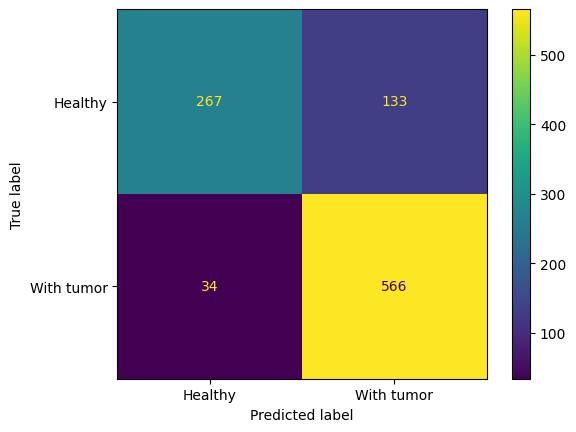

{'auc': [0.8950175642967224,
  0.9377156496047974,
  0.9568074941635132,
  0.9594067335128784,
  0.9644155502319336],
 'binary_accuracy': [0.8190000057220459,
  0.8737499713897705,
  0.903249979019165,
  0.9104999899864197,
  0.9259999990463257],
 'binary_crossentropy': [0.5952526926994324,
  0.5651007890701294,
  0.5518399477005005,
  0.5479589104652405,
  0.5416151881217957],
 'f1_score': [<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.77232695, 0.84979254], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.84282595, 0.8945059 ], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8785691 , 0.91959274], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8872795, 0.9257877], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.90726805, 0.9384359 ], dtype=float32)>],
 'loss': [0.5952526926994324,
  0.5651007890701294,
  0.5518399477005005,
  0.5479588508605957,
  0.5416152477264404]}

In [ ]:
print("Base Model Accuracy: ")
print(evaluation[1]*100)

confMatMRI = confusion_matrix(labelMRItestNP.argmax(axis=1), predictionMRI.argmax(axis=1)) # binary label types for conf matrix
dispConfMatMRI = ConfusionMatrixDisplay(confusion_matrix=confMatMRI, display_labels=["Healthy", "With tumor"])

dispConfMatMRI.plot()
plt.show()

trainedMRI.history

In [ ]:
# USING THE MODEL ON THE CT SCANS

trainedCT = cnnModel.fit(dataCTtrainNP, labelCTtrainNP, epochs=5, batch_size=100, shuffle=True)

predictionCT = (cnnModel.predict(dataCTtestNP, verbose=0) > 0.5).astype("int") # converts it from probability values to 0s and 1s (label equivalents)
evaluation = cnnModel.evaluate(dataCTtestNP, labelCTtestNP, verbose=0) # getting model accuracy

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 446s 12s/step - auc: 0.7841 - binary_accuracy: 0.7317 - binary_crossentropy: 0.6323 - f1_score: 0.7315 - loss: 0.6323
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 452s 12s/step - auc: 0.9342 - binary_accuracy: 0.8974 - binary_crossentropy: 0.5553 - f1_score: 0.8973 - loss: 0.5553
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 440s 12s/step - auc: 0.9390 - binary_accuracy: 0.9114 - binary_crossentropy: 0.5486 - f1_score: 0.9114 - loss: 0.5486
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 437s 12s/step - auc: 0.9480 - binary_accuracy: 0.9384 - binary_crossentropy: 0.5364 - f1_score: 0.9384 - loss: 0.5364
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 435s 12s/step - auc: 0.9460 - binary_accuracy: 0.9322 - binary_crossentropy: 0.5370 - f1_score: 0.9320 - loss: 0.5370


Base Model Accuracy: 
55.62770366668701


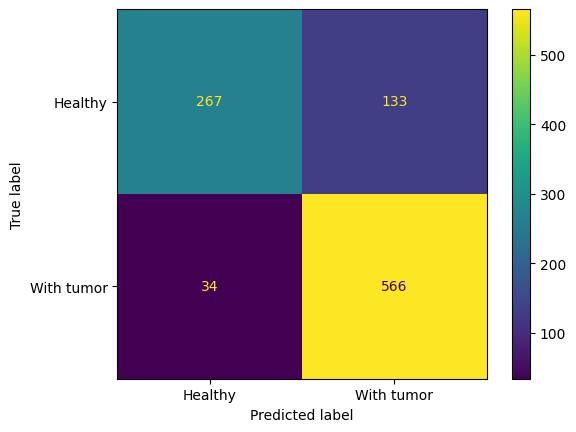

{'auc': [0.872430682182312,
  0.9341213703155518,
  0.9419378042221069,
  0.9476063251495361,
  0.9509006142616272],
 'binary_accuracy': [0.8178126811981201,
  0.8946940898895264,
  0.9158093929290771,
  0.9374661445617676,
  0.9377368688583374],
 'binary_crossentropy': [0.592214822769165,
  0.5563842058181763,
  0.5461785197257996,
  0.5366743803024292,
  0.5345847606658936],
 'f1_score': [<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.82019764, 0.8153634 ], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.89744264, 0.8917941 ], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9167335, 0.9148644], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.93798655, 0.93693686], dtype=float32)>,
  <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.9382715 , 0.93719274], dtype=float32)>],
 'loss': [0.5922322273254395,
  0.5564225912094116,
  0.5461617112159729,
  0.5367060899734497,
  0.5345962643623352]}

In [ ]:
print("Base Model Accuracy: ")
print(evaluation[1]*100)

confMatCT = confusion_matrix(labelCTtestNP.argmax(axis=1), predictionCT.argmax(axis=1)) # binary label types for conf matrix
dispConfMatCT = ConfusionMatrixDisplay(confusion_matrix=confMatCT, display_labels=["Healthy", "With tumor"])

dispConfMatMRI.plot()
plt.show()

trainedCT.history